## ON THE INTERPRETATION OF LEARNING DYNAMICAL SYSTEMS

In [1]:
#---------------------------------------
# Load Libs
#---------------------------------------
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm

import sklearn
import sklearn.manifold
from itertools import cycle
from collections import defaultdict

In [34]:
#---------------------------------------
# Load utility functions
#---------------------------------------
import importlib
import utils 
importlib.reload(utils)
from utils import *

import helper 
importlib.reload(helper)
from helper import *

In [3]:
#---------------------------------------
# Load torch
#---------------------------------------
import torch
device = get_device()

Connected to a GPU


In [4]:
#---------------------------------------
# Set seed
#---------------------------------------
import torch.nn.init as init
np.random.seed(0)
torch.manual_seed(0)

## Example 1: The Simple Harmonic Oscillator 

In [39]:
#---------------------------------------
# Example 1: The Simple Harmonic Oscillator 
# Create Data
#---------------------------------------

t_max = 50
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)

Lambda = np.array(([0,1],[-1,0]))
#Lambda = np.array(([-0.1,1],[-1,-0.1]))
u0 = np.array(([0,1]))
data = solution_general_linear(Lambda=Lambda, u0=u0, ts=anal_ts)


# send to torch
torch_data = data_to_torch(data, device)

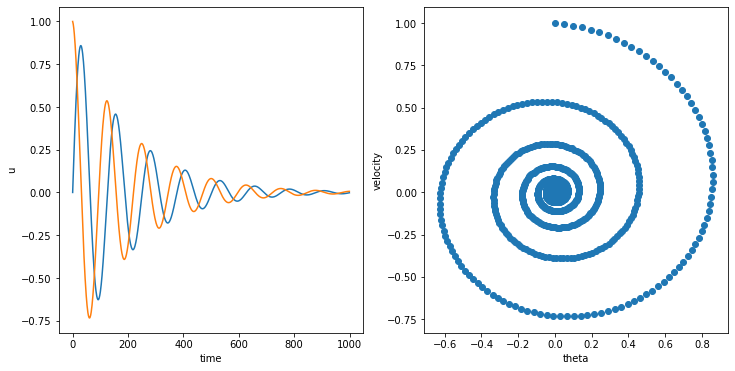

In [40]:
#---------------------------------------
# Plot Orbit and time series
#---------------------------------------
#fig, (ax1, ax2) = plt.subplots(1, 2)
FIG_SIZE_FULL = (12,6)
def trajectory_plots(trajs):
    plt.figure(figsize=FIG_SIZE_FULL)
    plt.subplot(1,2,1)
    for data in trajs:
        plt.plot(data)
    plt.ylabel('u')
    plt.xlabel('time')

    plt.subplot(1,2,2)
    for data in trajs:
        plt.scatter(data[:,0],data[:,1])
    plt.ylabel('velocity')
    plt.xlabel('theta')
trajectory_plots([data])

In [41]:
omega, losses, omega_trace  = learn_omega(torch_data, batch_size=25, device=device)

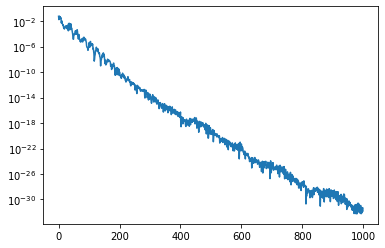

In [42]:
plt.semilogy(losses)

In [43]:
print('True Omega: \n', true_omega_linear(Lambda, dt=50/1000))
print('Lerned Omega: \n', omega.weight.data.cpu().numpy())

True Omega: 
 [[ 0.99376897  0.0497299 ]
 [-0.0497299   0.99376897]]
Lerned Omega: 
 [[ 0.99376151  0.04977939]
 [-0.04977939  0.99376151]]


In [44]:
omegas = []
omega_traces = []
for i in range(10):
    omega_temp, loss, omega_trace_temp = learn_omega(torch_data, batch_size=25, device=device)
    omegas.append( omega_temp.weight.data.cpu().numpy() )
    omega_traces.append( omega_trace_temp )

In [71]:
#omegas_exp = np.array([ np.array(OM) for oms in [experiments.values()] for OM in omega_traces ]).reshape((-1,4))
flattened_experiment_omegas = np.array([
    OM for OM in omegas
]).reshape((-1,4))
flattened_traces_omegas = np.array([
    OM for OMS in omega_traces for OM in OMS
]).reshape((-1,4))
list_of_traces_omegas = [
    np.array(OMS).reshape((-1,4)) for OMS in omega_traces ]

In [46]:
path_of_omega_alpha = np.array([one_step_factory(Lambda,dt,alpha) for alpha in np.linspace(0,1,100) ]).reshape((-1,4))

In [59]:
known_omegas = {'True':true_omega_linear(Lambda,dt)}
known_omegas.update({
    method:operator_factory(Lambda,dt,method) 
                for method in ['euler', 'bweuler', 'implicit_trap', 'midpoint','rk4'] })

In [55]:
all_omegas = np.concatenate([
    flattened_traces_omegas,
    path_of_omega_alpha,
    ] + [OM.reshape((-1,4)) for OM in known_omegas.values() ]
    )

In [78]:
def plot_embedding(TRANSFER, experimental_omegas, path_omega, known_omegas, traces=None):
    """Embed and plot the operators, given a callback to the embedding object."""
    X_trans_alpha = TRANSFER(path_omega)
    X_trans_exps = TRANSFER(experimental_omegas)
    X_trans_known = { n:TRANSFER(omega.reshape(-1,4)) for n,omega in known_omegas.items()}
    all_points = cycle('soo*xxxxx')
    markerdict = defaultdict(lambda : next(all_points))
    plt.figure(figsize=(12,7))
    # That path of the family
    plt.plot(X_trans_alpha[:,0],X_trans_alpha[:,1],'-', lw=3)
    # Known operators
    for n,X in X_trans_known.items():
        plt.plot(X[:,0],X[:,1],markerdict[n],label=n, markersize=15)
    # fix axis
    #xlim= plt.xlim()
    # The end points
    for t in traces:
        X=TRANSFER(t)
        plt.plot(X[:,0],X[:,1],'--')
        
    gap = 0.1
    plt.xlim((X_trans_alpha[:,0].min()-gap,X_trans_alpha[:,0].max()+gap))
    plt.ylim((X_trans_alpha[:,1].min()-gap,X_trans_alpha[:,1].max()+gap))
    # The paths
    plt.plot(X_trans_exps[:,0],X_trans_exps[:,1],'+',label='experiments', markersize=15)
    plt.xlabel("first principal component", fontsize=22)
    plt.ylabel("second principal component", fontsize=22)
    plt.set_cmap('Set3')
    plt.tick_params(axis='x', labelsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.legend(fontsize=16)
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


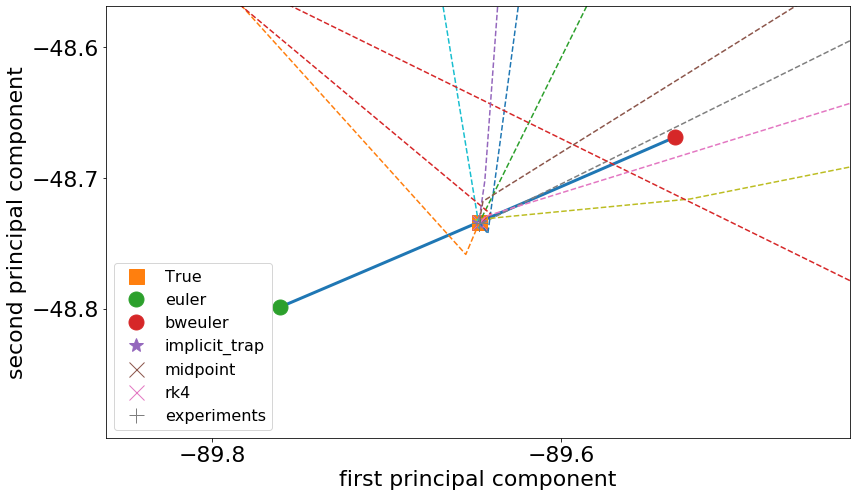

In [79]:
all_omegas_standardized = sklearn.preprocessing.scale(all_omegas, axis=0, with_mean=True, with_std=True, copy=True)
pca = sklearn.decomposition.PCA(n_components=2, svd_solver='full', whiten=True)
pca.fit(all_omegas_standardized)
plot_embedding(lambda X : pca.transform(X) / 1e-2,
              flattened_experiment_omegas,
              path_of_omega_alpha,
              known_omegas,
              list_of_traces_omegas)
plt.savefig('pca_linear_experiment' +'.eps')


## Example 2: The Damped Harmonic Oscillator 